In [1]:
import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
import numpy as np
import pickle
import networkx as nx
from dataloader import *
from RGCN import *

In [2]:
with open("DGL_graph.pkl", "rb") as f:
    g = pickle.load(f)
    
with open("data/conceptnet/embedding_values.pkl", "rb") as f:
    embedding_values = pickle.load(f)
        
g.ndata["x"] = embedding_values

# subsample a strongly-connected subgraph

G_nx = g.to_networkx()
sub_G_nx = nx.strongly_connected_components(G_nx)
SCC = []
for item in sub_G_nx:
    if len(item) > 2:
        SCC.append(item)
component = list(SCC[0])

# assign embedding to graph
sub_graph = g.subgraph(component)
sub_graph.copy_from_parent()
sub_graph_G = sub_graph

X,y = gen_training_set(sub_graph_G, 3, 100)
print(len(X), len(y))

100 100


In [3]:
# configurations
n_hidden = 16 # number of hidden units
n_bases = -1 # use number of relations as number of bases
n_hidden_layers = 0 # use 1 input layer, 1 output layer, no hidden layer
n_epochs = 25 # epochs to train
lr = 0.01 # learning rate
l2norm = 0 # L2 norm coefficient

SOS_token = len(g)
EOS_token = len(g) + 1

n_input = 300
n_output = 256
num_rels = 34


# create graph
edge_norm = torch.ones(g.edata['rel_type'].shape[0])
g.edata.update({'norm': edge_norm.view(-1,1)})

# create model
model = Model(n_input,
              n_hidden,
              n_output,
              num_rels,
              num_bases=n_bases,
              num_hidden_layers=n_hidden_layers)

In [4]:
g.ndata['x'] = g.ndata['x'].float()
output, g_emb = model(g)

In [5]:
from model import *

class graph_to_graph(nn.Module):
    # take a Commonsense graph as input, output generated new nodes(phrase) and edges(phrase)
    def __init__(self, input_size, hidden_size, node_output_size, phrase_output_size, edge_output_size, num_rels, n_hidden_layers, n_bases = -1):
        super(graph_to_graph, self).__init__()
        self.node = LSTM_node_generator(hidden_size, node_output_size)
        #self.phrase = LSTM_phrase_generator(hidden_size, phrase_output_size) #TODO: replace by gpt-2
        #self.edge = LSTM_edge_generator(hidden_size, edge_output_size)
        # USE vanilla GCN
        #self.graph_encoder = Net(input_size, 256, hidden_size)
        # USE R-GCN
        self.graph_encoder = Model(input_size,
              hidden_size,
              hidden_size,
              num_rels,
              num_bases=n_bases,
              num_hidden_layers=n_hidden_layers)
        
    def generate_graph_embedding(self, g):
        return self.graph_encoder(g)
    
    def node_policy(self, *args):
        return self.node(*args)
       
    def generate_node_baseline(self, g):
        node_embedding, g_embedding = self.graph_encoder(g)
        node_embedding = list(node_embedding)
        
        node_decoder_input = torch.tensor([[SOS_token]], device=device)
        node_decoder_hidden = (g_embedding.view(1,1,-1), torch.zeros_like(g_embedding).view(1,1,-1))
        
        new_node_list = []
        
        # TODO: implementing teacher-forcing
        for ni in range(max_length):
            node_decoder_output, node_decoder_hidden = self.node(
                node_decoder_input, node_decoder_hidden)
            new_node_embedding = node_decoder_hidden
            topv, topi = node_decoder_output.topk(1)
            node_decoder_input = topi.squeeze().detach()  # detach from history as input
            print(node_decoder_input)
            if node_decoder_input.item() == EOS_token: # stop generating node
                break
            else:  # new node embedding generated
                new_node_list.append(node_decoder_input.item())
        return new_node_list
    
    

In [52]:
#from model import *
CORPUS_SIZE = 10000
input_size = 300
hidden_size = 16
node_output_size = g.ndata['x'].shape[0] + 2
phrase_output_size = CORPUS_SIZE
edge_output_size = CORPUS_SIZE
num_rels = 34
n_hidden_layers = 2
n_bases = -1

graph_generator = graph_to_graph(input_size, 
                                 hidden_size, 
                                 node_output_size, 
                                 phrase_output_size, 
                                 edge_output_size, 
                                 num_rels, 
                                 n_hidden_layers, 
                                 n_bases = -1)

In [53]:
graph_S = sub_graph_G.subgraph(X[0])
graph_S.copy_from_parent()

graph_S.ndata["x"] = graph_S.ndata["x"].float()
edge_norm = torch.ones(graph_S.edata['rel_type'].shape[0])
graph_S.edata.update({'norm': edge_norm.view(-1,1)})

In [54]:
# Policy gradient
from torch.distributions import Categorical

gamma = 1
class Policy(nn.Module):
    # Wrap up the LSTM decisions
    def __init__(self):
        super(Policy, self).__init__()
        #self.state_space = env.observation_space.shape[0]
        #self.action_space = env.action_space.n

        self.gamma = gamma
        self.graph_generator =  graph_to_graph(input_size, 
                                 hidden_size, 
                                 node_output_size, 
                                 phrase_output_size, 
                                 edge_output_size, 
                                 num_rels, 
                                 n_hidden_layers, 
                                 n_bases = -1)
        
        # Episode policy and reward history 
        self.policy_history = torch.Tensor([])
        self.reward_episode = []
        # Overall reward and loss history
        self.reward_history = []
        self.loss_history = []
        self.action_history = []
        
    def forward(self, *args):    
            return self.graph_generator.node_policy(*args)

def select_action(policy, *args):
    # state: (h_i, c_i), h_i ~ (1,1,hid_dim)
    #Select an action (0 or 1) by running policy model and choosing based on the probabilities in state
    d_action,state = policy(*args)
    c = Categorical(torch.exp(d_action))
    action = c.sample()

    # Add log probability of our chosen action to our history    
    if policy.policy_history.dim() != 0:
        #print(policy.policy_history.shape, c.log_prob(action).shape)
        policy.policy_history = torch.cat([policy.policy_history, c.log_prob(action).view(-1)])
    else:
        policy.policy_history = (c.log_prob(action))
    return action, state


In [55]:
policy = Policy()

In [56]:
node_embedding, g_embedding = graph_generator.generate_graph_embedding(graph_S)

node_decoder_input = torch.tensor([[SOS_token]], device=device)
node_decoder_hidden = g_embedding
node_decoder_hidden = (g_embedding.view(1,1,-1), torch.zeros_like(g_embedding).view(1,1,-1))

output = select_action(policy, node_decoder_input, node_decoder_hidden)

In [57]:
def update_policy():
    R = 0
    rewards = []
    
    # Discount future rewards back to the present using gamma
    for r in policy.reward_episode[::-1]:
        R = r + policy.gamma * R
        rewards.insert(0,R)
        
    # Scale rewards
    rewards = torch.FloatTensor(rewards)
    #print(rewards)
    rewards = (rewards - rewards.mean()) / (rewards.std() + np.finfo(np.float32).eps)
    
    # Calculate loss
    loss = (torch.sum(torch.mul(policy.policy_history, rewards).mul(-1), -1))
    # Update network weights
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    
    #Save and intialize episode history counters
    policy.loss_history.append(loss.item)
    policy.reward_history.append(np.sum(policy.reward_episode))
    policy.policy_history = torch.Tensor()
    policy.reward_episode= []
    policy.action_history = []
    return loss.item()

In [63]:
import itertools
policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=5e-3)

def main(episodes):
    running_reward = 10
    for episode in range(episodes):
        #state = env.reset() # Reset environment and record the starting state
        # initial state:
        #policy = Policy(graph_generator)
        node_embedding, g_embedding = policy.graph_generator.generate_graph_embedding(graph_S)
        node_decoder_input = torch.tensor([[SOS_token]], device=device)
        node_decoder_hidden = g_embedding
        node_decoder_hidden = (g_embedding.view(1,1,-1), torch.zeros_like(g_embedding).view(1,1,-1))

        for time in range(3):
            action, state = select_action(policy, node_decoder_input, node_decoder_hidden)
            policy.action_history.append(action.item())
            # Step through environment using chosen action
            #state, reward, done, _ = env.step(action.data[0])
            #reward = compute_reward(policy.action_history, y[0])
            node_decoder_input = action
            node_decoder_hidden = state
            # Save reward
            if action.item() == EOS_token: # stop generating node
                reward = compute_reward(policy.action_history, y[0])
                policy.reward_episode.append(reward)
                break
            reward = 0
            policy.reward_episode.append(reward)
        if time == 2:
            reward = compute_reward(policy.action_history, y[0])
            policy.reward_episode[-1] = reward
        # Used to determine when the environment is solved.
        running_reward = (running_reward * 0.99) + (time * 0.01)
        action_history = policy.action_history
        loss = update_policy()
        if episode % 50 == 0:
            print(action_history)
            print('Episode {}\tLast length: {:5d}\tAverage length: {:.2f}\t Loss: {:.4f}'.format(episode, time, running_reward, loss))

In [64]:
def compute_reward(action_history, y):
    #print(action_history, y)
    score = len(set(y).intersection(set(action_history)))
    return score

In [65]:
main(10000)

[590, 189, 3863]
Episode 0	Last length:     2	Average length: 9.92	 Loss: 0.0000
[1564, 420, 2063]
Episode 50	Last length:     2	Average length: 6.79	 Loss: 0.0000
[2178, 1141, 1757]
Episode 100	Last length:     2	Average length: 4.90	 Loss: 0.0000
[1700, 3077, 1119]
Episode 150	Last length:     2	Average length: 3.75	 Loss: 0.0000
[3369, 2248, 36]
Episode 200	Last length:     2	Average length: 3.06	 Loss: 0.0000
[102, 2902, 4404]
Episode 250	Last length:     2	Average length: 2.64	 Loss: 0.0000
[2079, 887, 176]
Episode 300	Last length:     2	Average length: 2.39	 Loss: 0.0000
[454, 3049, 2125]
Episode 350	Last length:     2	Average length: 2.23	 Loss: 0.0000
[1007, 681, 3019]
Episode 400	Last length:     2	Average length: 2.14	 Loss: 0.0000
[2204, 1976, 598]
Episode 450	Last length:     2	Average length: 2.09	 Loss: 0.0000
[2715, 4242, 2305]
Episode 500	Last length:     2	Average length: 2.05	 Loss: 0.0000
[2322, 981, 1405]
Episode 550	Last length:     2	Average length: 2.03	 Loss: 0.

RuntimeError: invalid multinomial distribution (encountering probability entry < 0)

In [34]:
y[0]

[683, 889, 1062]

In [93]:
def supervised_train(graph_encoder, node_decoder, iteration, X, y):
    y = torch.Tensor(y).long()
    g_list = []
    for i in range(len(X)):    
        g = sub_graph_G.subgraph(X)
        g.copy_from_parent()
        g.ndata["x"] = g.ndata["x"].float()
        edge_norm = torch.ones(g.edata['rel_type'].shape[0])
        g.edata.update({'norm': edge_norm.view(-1,1)})
        g_list.append(g)
    batch_graph = dgl.batch(g_list)
    
    graph_encoder_optimizer = optim.SGD(graph_encoder.parameters(), lr=1e-3)
    node_decoder_optimizer = optim.SGD(node_decoder.parameters(), lr=1e-3)
    
    criterion = nn.NLLLoss()
    
    for i in range(iteration):
        loss = 0
        node_embedding, g_embedding = graph_encoder(g)

        node_decoder_input = torch.tensor([[SOS_token]], device=device)
        node_decoder_hidden = (g_embedding.view(1,1,-1), torch.zeros_like(g_embedding).view(1,1,-1))

        new_node_list = []

        # TODO: implementing teacher-forcing
        output = []
        for ni in range(len(y)):
            node_decoder_output, node_decoder_hidden = node_decoder(
                node_decoder_input, node_decoder_hidden)
            new_node_embedding = node_decoder_hidden
            topv, topi = node_decoder_output.topk(1)
            node_decoder_input = topi.squeeze().detach()  # detach from history as input
            if node_decoder_input.item() == EOS_token: # stop generating node
                break
            #print(node_decoder_output, y[ni])
            loss += criterion(node_decoder_output.view(1,-1), y[ni].view(1))
            output.append(node_decoder_input.item())

        loss.backward()

        graph_encoder_optimizer.step()
        node_decoder_optimizer.step()
        
        if i % 100 == 0:
            print(output)
            print("Iteration {}/{}, loss:{:.2f}".format(i, iteration, loss.item()))

In [94]:
CORPUS_SIZE = 10000
input_size = 300
hidden_size = 16
node_output_size = g.ndata['x'].shape[0] + 2
phrase_output_size = CORPUS_SIZE
edge_output_size = CORPUS_SIZE
num_rels = 34
n_hidden_layers = 2
n_bases = -1

node_generator = LSTM_node_generator(hidden_size, node_output_size)
graph_encoder = Model(input_size,
              hidden_size,
              hidden_size,
              num_rels,
              num_bases=n_bases,
              num_hidden_layers=n_hidden_layers)

In [95]:
supervised_train(graph_encoder, node_generator, 1000, X[0], y[0])

[3640, 599, 240]
Iteration 0/1000, loss:25.14
[889, 1062, 1062]
Iteration 100/1000, loss:2.77
[683, 889, 1062]
Iteration 200/1000, loss:0.32
[683, 889, 1062]
Iteration 300/1000, loss:0.00
[683, 889, 1062]
Iteration 400/1000, loss:0.00
[683, 889, 1062]
Iteration 500/1000, loss:0.00
[683, 889, 1062]
Iteration 600/1000, loss:0.00
[683, 889, 1062]
Iteration 700/1000, loss:0.00
[683, 889, 1062]
Iteration 800/1000, loss:0.00
[683, 889, 1062]
Iteration 900/1000, loss:0.00


In [96]:
subgraph_g1 = sub_graph_G.subgraph(X[0])
subgraph_g1.copy_from_parent()
subgraph_g1.ndata["x"] = subgraph_g1.ndata["x"].float()
edge_norm = torch.ones(subgraph_g1.edata['rel_type'].shape[0])
subgraph_g1.edata.update({'norm': edge_norm.view(-1,1)})

subgraph_g2 = sub_graph_G.subgraph(X[1])
subgraph_g2.copy_from_parent()
subgraph_g2.ndata["x"] = subgraph_g2.ndata["x"].float()
edge_norm = torch.ones(subgraph_g2.edata['rel_type'].shape[0])
subgraph_g2.edata.update({'norm': edge_norm.view(-1,1)})

batch_graph = dgl.batch([subgraph_g1,subgraph_g2])

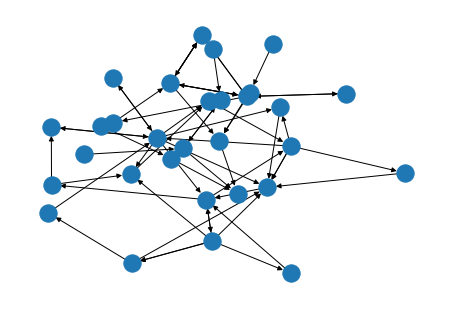

In [99]:
import matplotlib.pyplot as plt
%matplotlib inline

nx_g = batch_graph.to_networkx()
pos = nx.kamada_kawai_layout(nx_g)
nx.draw(nx_g, pos)
plt.show()

In [105]:
node_embedding, g_embedding = graph_encoder(batch_graph)
node_embedding.shape

torch.Size([30, 16])